In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.generators.degree_seq import random_degree_sequence_graph
from networkx.algorithms.graphical import is_graphical
from networkx.utils.random_sequence import powerlaw_sequence
import matplotlib.pyplot as plt
plt.style.use('../figures/norm.mplstyle')
from ldpc.code_util import *
from ldpc.mod2 import *
from bposd.hgp import hgp
from bposd.css import css_code, compute_code_distance
import sys, os
from timeit import default_timer as timer
import cairo
import cmath

def read_pc(filepath):
    """
    Read parity check matrix from file.
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()
    pc = []
    for line in lines:
        row = [int(x) for x in line.split()]
        pc.append(row)
    return np.array(pc, dtype=np.uint8)

def get_classical_code_distance(h):
    if rank(h) == h.shape[1]:
        print('Code is full rank, no codewords')
        return np.inf
    else:
        start = timer()
        ker = nullspace(h)
        end = timer()
        print('len of ker: ', len(ker))
        start = end
        # @jit
        def find_min_weight_while_build(matrix):
            span = []
            min_hamming_weight = np.inf
            for ir, row in enumerate(matrix):
                print('debug: ir = ', ir, 'current min_hamming_weight = ', min_hamming_weight, flush=True)  # debug
                row_hamming_weight = np.sum(row)
                if row_hamming_weight < min_hamming_weight:
                    min_hamming_weight = row_hamming_weight
                temp = [row]
                for element in span:
                    newvec = (row + element) % 2
                    temp.append(newvec)
                    newvec_hamming_weight = np.sum(newvec)
                    if newvec_hamming_weight < min_hamming_weight:
                        min_hamming_weight = newvec_hamming_weight
                    
                    end = timer()
                    if end - start > 60:
                        print('Elapsed time for finding minimum Hamming weight while buiding codeword space : ', end-start, ' seconds', flush=True)
                        return min_hamming_weight
                span = list(np.unique(temp + span, axis=0))
            assert len(span) == 2**len(matrix) - 1
            return min_hamming_weight
        min_hamming_weight = find_min_weight_while_build(ker)
        end = timer()
        print(f'Elapsed time for finding minimum Hamming weight while buiding codeword space : {end-start} seconds', flush=True)
        
        return min_hamming_weight

In [12]:
kmax_bit, kmax_check = 6, 10
kmin_bit, kmin_check = 3, 3
r, density = 0.8, 50
n, m = np.array([100, 100]) * 2
n, m = int(n), int(m)
seeds = range(6,7)
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/ldpc_code'

ns_eff = []
ms_eff = []
ks = []
ds = []
for seed in seeds:
    # ms_eff.append([])
    # ns_eff.append([])
    # ks.append([])
    # ds.append([])
    # readname = f'hclassical_kdtreealgo_local_n={n}_m={m}_kmax_bit={kmax_bit}_kmax_check={kmax_check}_kmin_bit={kmin_bit}_kmin_check={kmin_check}_r={r}_density={density}_seed={seed}.txt'
    readname = f'pc_local_ldpc_bound_below_n={n}_m={m}_kmin_bit={kmin_bit}_kmin_check={kmin_check}_seed={seed}.txt'
    filepath = os.path.join(readdir, readname)
    if os.path.exists(filepath):
        h = read_pc(filepath)
        # k = len(row_basis(nullspace(h)))
        k = h.shape[1] - rank(h)
        d = get_classical_code_distance(h)
        m_eff, n_eff = h.shape

        ks.append(k)
        ds.append(d)
        ns_eff.append(n_eff)
        ms_eff.append(m_eff)
        print('d = ', d)

Code is not full rank, there are codewords
len of ker:  8
Start finding minimum Hamming weight while buiding codeword space ...
debug: ir =  0 current min_hamming_weight =  inf
debug: ir =  1 current min_hamming_weight =  2
debug: ir =  2 current min_hamming_weight =  2
debug: ir =  3 current min_hamming_weight =  2
debug: ir =  4 current min_hamming_weight =  2
debug: ir =  5 current min_hamming_weight =  2
debug: ir =  6 current min_hamming_weight =  2
debug: ir =  7 current min_hamming_weight =  2
Elapsed time for finding minimum Hamming weight while buiding codeword space : 0.008905416999994031 seconds
d =  2


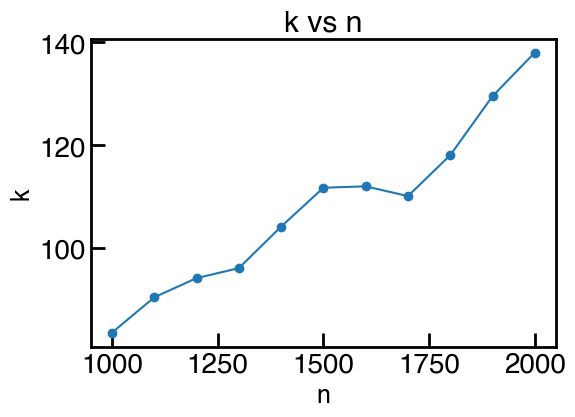

In [143]:
kmax_bit, kmax_check = 6, 10
kmin_bit, kmin_check = 3, 3
r, density = 0.8, 50
const = 5
ns = np.arange(1000, 2050, 100)
ms = np.arange(1000, 2050, 100)
seeds = range(51)
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/ldpc_code'

ns_eff = []
ms_eff = []
ks = []
ds = []
for n, m in zip(ns, ms):
    ms_eff.append([])
    ns_eff.append([])
    ks.append([])
    # ds.append([])
    for seed in seeds:
        # readname = f'hclassical_kdtreealgo_local_n={n}_m={m}_kmax_bit={kmax_bit}_kmax_check={kmax_check}_kmin_bit={kmin_bit}_kmin_check={kmin_check}_r={r}_density={density}_seed={seed}.txt'
        readname = f'pc_local_ldpc_bound_below_n={n}_m={m}_kmin_bit={kmin_bit}_kmin_check={kmin_check}_const={const}_seed={seed}.txt'
        filepath = os.path.join(readdir, readname)
        if os.path.exists(filepath):
            h = read_pc(filepath)
            k = h.shape[1] - rank(h)
            # d = get_classical_code_distance(h)
            m_eff, n_eff = h.shape

            ms_eff[-1].append(m_eff)
            ns_eff[-1].append(n_eff)
            ks[-1].append(k)
            # ds[-1].append(get_classical_code_distance(h))

ks = [np.average(k) for k in ks]
# d = np.average(ds, axis=0)
ns_eff = [np.average(n) for n in ns_eff]
ms_eff = [np.average(m) for m in ms_eff]
# print('k = ', k)
# print('d = ', d)
# print('n_eff = ', n_eff)
# print('m_eff = ', m_eff)
fig, ax = plt.subplots()
ax.plot(ns, ks, 'o-')
ax.set_xlabel('n')
ax.set_ylabel('k')
ax.set_title('k vs n')
plt.show()

In [138]:
np.savez('local_ldpc_code_data_prune_checks_refill_bits_cutoff.npz', ns=ns, ms=ms, ks=ks, ns_eff=ns_eff, ms_eff=ms_eff)

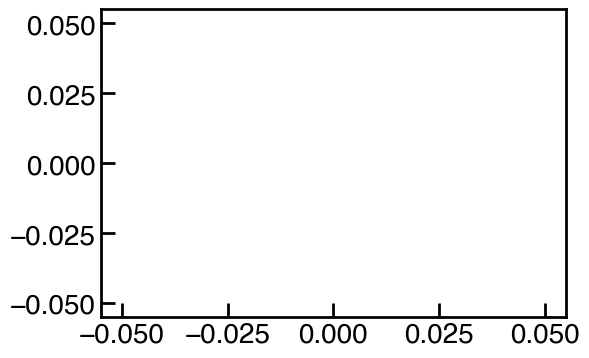

In [136]:
data = np.load('local_ldpc_code_data_prune_checks_refill_bits_no_cutoff.npz', allow_pickle=True)
ns = data['ns']
ms = data['ms']
ks = data['ks']
plt.figure()
plt.plot(ns, ks, 'o-')
plt.show()

/Users/yitan/anaconda3/envs/qec_numerics/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/yitan/anaconda3/envs/qec_numerics/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


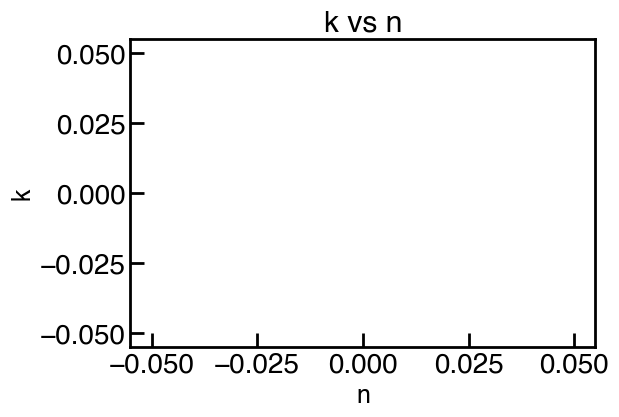

In [137]:
ks = [np.average(k) for k in ks]
# d = np.average(ds, axis=0)
ns_eff = [np.average(n) for n in ns_eff]
ms_eff = [np.average(m) for m in ms_eff]
# print('k = ', k)
# print('d = ', d)
# print('n_eff = ', n_eff)
# print('m_eff = ', m_eff)
fig, ax = plt.subplots()
ax.plot(ns, ks, 'o-')
ax.set_xlabel('n')
ax.set_ylabel('k')
ax.set_title('k vs n')
plt.show()

[0.28513258 0.81594839]


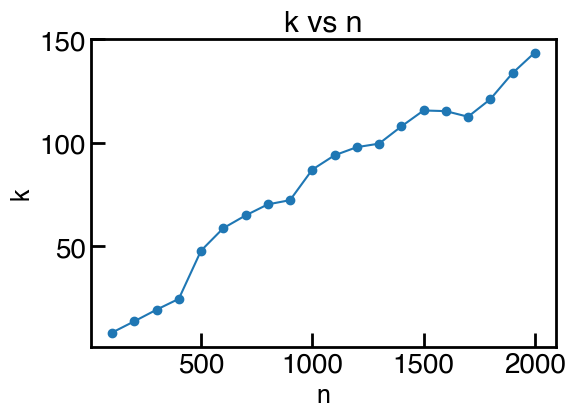

In [127]:
from scipy.optimize import curve_fit
# power law fit
def func(x, a, b):
    return a * x**b

popt, pcov = curve_fit(func, ns, ks)
print(popt)

fig, ax = plt.subplots()
ax.plot(ns, ks, 'o-')

# plot 0.2*n
# ax.plot(ns, 0.2*ns)

ax.set_xlabel('n')
ax.set_ylabel('k')
ax.set_title('k vs n')
plt.show()

### Stats of the removed checks' distances from boundary

In [14]:
def bin_points(point, linear_size, nbars=5):
    x, y = point
    x = x / linear_size
    y = y / linear_size
    if x > 0.5:
        x = 1. - x
    if y > 0.5:
        y = 1. - y
    lookat = min(x, y)
    k = np.floor(lookat/(0.5/(nbars)))
    return k

#### Stats for checks

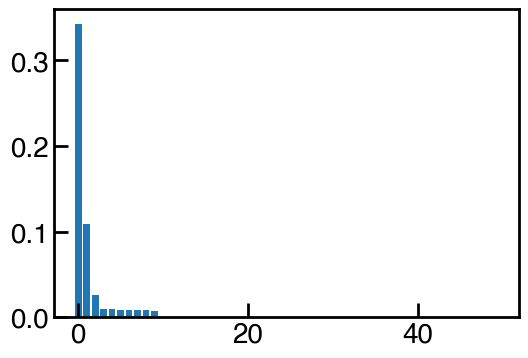

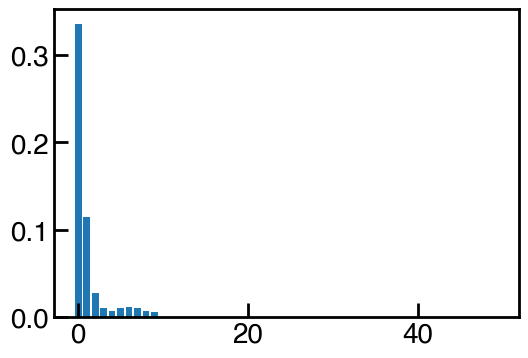

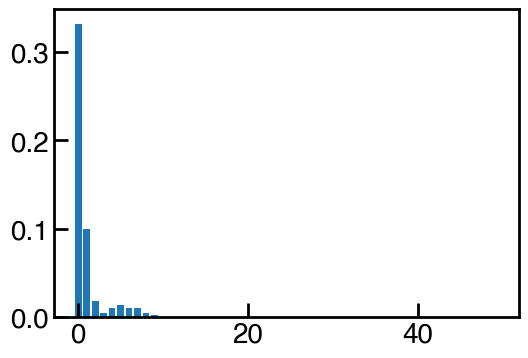

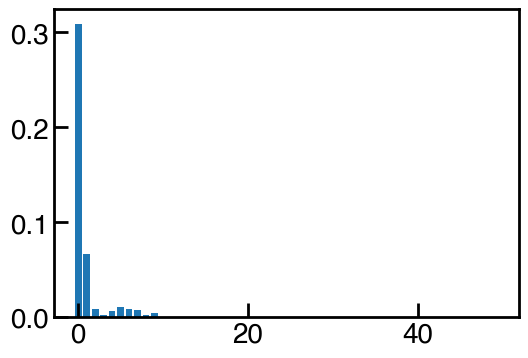

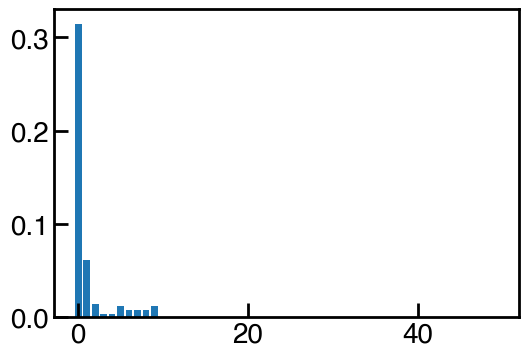

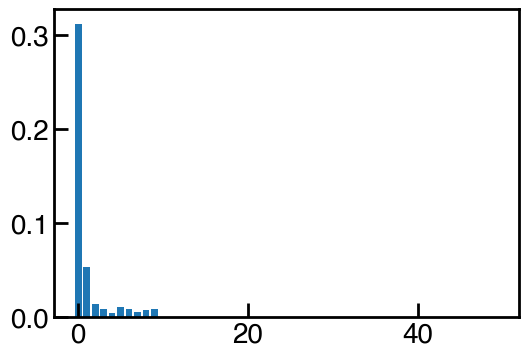

In [141]:
kmax_bit, kmax_check = 6, 10
kmin_bit, kmin_check = 3, 3
r, density = 0.8, 50
const = 5
# n, m = np.array([100, 100]) * 27
# n, m = n.astype(int), m.astype(int)
ns = np.arange(1000, 1550, 100)
ms = np.arange(1000, 1550, 100)
seeds = range(21)
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/ldpc_code'

for n, m in zip(ns, ms):
    ns_eff = []
    ms_eff = []
    ks = []
    ds = []
    stats = []
    nums = []
    nbars = 50
    for seed in seeds:
        readname = f'removed_check_data_local_ldpc_bound_below_n={n}_m={m}_kmin_bit={kmin_bit}_kmin_check={kmin_check}_const={const}_seed={seed}.npz'
        filepath = os.path.join(readdir, readname)
        if os.path.exists(filepath):
            # linear_size = np.sqrt((m+n)/density)
            linear_size = 1
            data = np.load(filepath, allow_pickle=True)
            if len(data['removed_checks']):
                removed_checks = data['removed_checks']
                removed_checks_points = data['removed_checks_points']
                stats += [bin_points(point, linear_size, nbars=nbars) for point in removed_checks_points]

    hist = np.histogram(stats, bins=np.arange(nbars+1))
    areas = np.array([((nbars-k)**2 - (nbars-1-k)**2) * (0.5/(nbars))**2 * 4 for k in range(0, nbars)])
    data, bars = hist[0], hist[1]
    data = data / areas
    data /= (n*len(seeds))
    fig, ax = plt.subplots()
    ax.bar(np.arange(nbars), data)

#### Stats for bits

In [113]:
kmax_bit, kmax_check = 6, 10
kmin_bit, kmin_check = 3, 3
r, density = 0.8, 50
const = 5
ns = np.arange(500, 1050, 100)
ms = np.arange(500, 1050, 100)
seeds = range(21)
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/ldpc_code'


for n, m in zip(ns, ms):
    ns_eff = []
    ms_eff = []
    ks = []
    ds = []
    stats = []
    nums = []
    nbars = 50
    for seed in seeds:
        readname = f'removed_check_data_local_ldpc_bound_below_n={n}_m={m}_kmin_bit={kmin_bit}_kmin_check={kmin_check}_const={const}_seed={seed}.npz'
        filepath = os.path.join(readdir, readname)
        if os.path.exists(filepath):
            # linear_size = np.sqrt((m+n)/density)
            linear_size = 1
            data = np.load(filepath, allow_pickle=True)
            if len(data['removed_bits']):
                removed_bits = data['removed_bits']
                points = data['points']
                removed_bits_points = points[removed_bits]
                stats += [bin_points(point, linear_size, nbars=nbars) for point in removed_bits_points]

    hist = np.histogram(stats, bins=np.arange(nbars+1))
    areas = np.array([((nbars-k)**2 - (nbars-1-k)**2) * (0.5/(nbars))**2 * 4 for k in range(0, nbars)])
    data, bars = hist[0], hist[1]
    data = data / areas
    data /= (n*len(seeds))
    fig, ax = plt.subplots()
    ax.bar(np.arange(nbars), data)

KeyError: 'removed_bits is not a file in the archive'

#### $n^\prime - m^\prime$

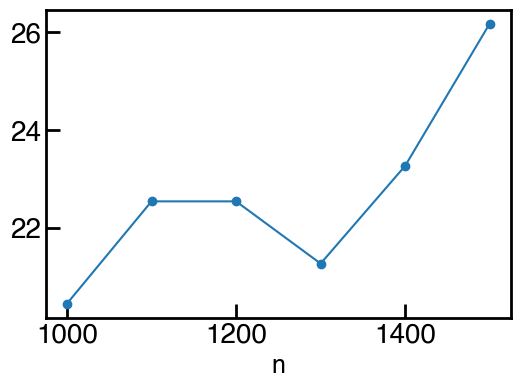

In [142]:

kmax_bit, kmax_check = 6, 10
kmin_bit, kmin_check = 3, 3
r, density = 0.8, 50
const = 5
ns = np.arange(1000, 1550, 100)
ms = np.arange(1000, 1550, 100)
seeds = range(11)
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/ldpc_code'

ns_eff = []
ms_eff = []
ks = []
ds = []
for n, m in zip(ns, ms):
    ms_eff.append([])
    ns_eff.append([])
    ks.append([])
    # ds.append([])
    for seed in seeds:
        # readname = f'hclassical_kdtreealgo_local_n={n}_m={m}_kmax_bit={kmax_bit}_kmax_check={kmax_check}_kmin_bit={kmin_bit}_kmin_check={kmin_check}_r={r}_density={density}_seed={seed}.txt'
        readname = f'pc_local_ldpc_bound_below_n={n}_m={m}_kmin_bit={kmin_bit}_kmin_check={kmin_check}_const={const}_seed={seed}.txt'
        filepath = os.path.join(readdir, readname)
        if os.path.exists(filepath):
            h = read_pc(filepath)
            # k = h.shape[1] - rank(h)
            # d = get_classical_code_distance(h)
            m_eff, n_eff = h.shape

            ms_eff[-1].append(m_eff)
            ns_eff[-1].append(n_eff)
            # ks[-1].append(k)
            # ds[-1].append(get_classical_code_distance(h))

# ks = [np.average(k) for k in ks]
# d = np.average(ds, axis=0)
ns_eff = np.array([np.average(n) for n in ns_eff])
ms_eff = np.array([np.average(m) for m in ms_eff])
# print('k = ', k)
# print('d = ', d)
# print('n_eff = ', n_eff)
# print('m_eff = ', m_eff)
fig, ax = plt.subplots()
ax.plot(ns, ns-ms_eff, 'o-')
ax.set_xlabel('n')
plt.show()